In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
import keras.backend as K
from keras.utils import multi_gpu_model, np_utils
from keras.models import load_model
from keras.models import model_from_json
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import os
import warnings
warnings.simplefilter("ignore", np.RankWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
GPU_MEMORY_FRACTION = 1.0
DATA_SHAPE = 224

In [2]:
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)

# config_keras_backend(GPU_MEMORY_FRACTION)
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
val_masks = np.load('/home/mc16/result/val_seg_06-13-14:49:58.npy')
test_masks = np.load('/home/mc16/result/test1_seg_06-13-14:46:16.npy')

In [4]:
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('seg0608.h5')
# model = model_from_json(open('/home/mc16/model3/segmodel_structure_1.json').read())
# model.load_weights('/home/mc16/model3/segmodel_weights_1.h5')

/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# CRF

In [11]:
def crf_image(img, model, gdims=(2,3), bdims=(20,100), iteras=1):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    # The input should be the negative of the logarithm of probability values
    # Look up the definition of the softmax_to_unary for more information
    unary = unary_from_softmax(softmax)
    # The inputs should be C-continious -- we are using Cython wrapper
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    feats = create_pairwise_gaussian(sdims=gdims, shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features --
    # because the segmentation that we get from CNN are too coarse
    # and we can use local color features to refine them
    feats = create_pairwise_bilateral(sdims=bdims, schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # mean field iteration
    Q = crf.inference(iteras)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

In [93]:
def cut_top(mask, frac=0.3):
    cut_mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    cut_top = 0
    for i in range(len(sum_mask)):
        if sum_mask[i] > 5:
            cut_top = i
            break
    cut_down = cut_top + int((224 - cut_top) * frac)
    cut_mask[:cut_down,:] = 0
    return cut_mask

def cut_shit(mask, num, frac=0.7):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_L = i + int(num * (1 - frac) / 2)
                cut_R = i + int(num * (1 + frac) / 2)
                cut_mask[j, cut_L:cut_R] = 0
    return cut_mask

44


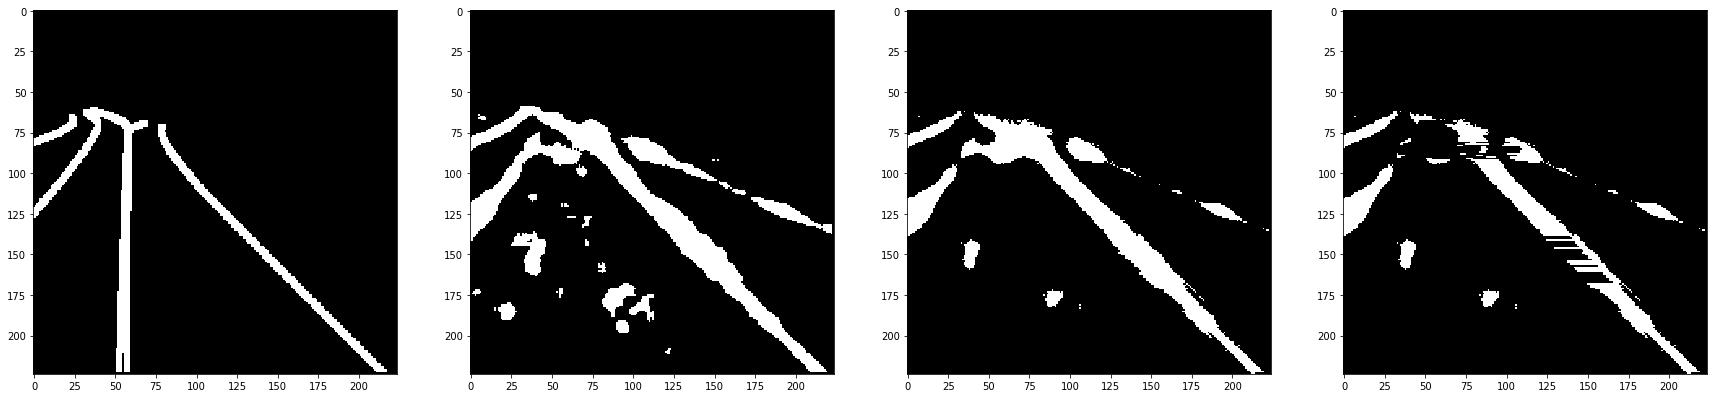

In [95]:
test_index = random.randint(0, len(val_labels))
# test_index = 1820
print(test_index)
test_img = val_images[test_index]
test_label = val_labels[test_index,:,:,1]
test_mask = val_masks[test_index]
test_crf = crf_image(test_img, model, gdims=(3,3), bdims=(7,7), iteras=1)
cut_mask = cut_shit(test_crf, 30)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_label,cmap='gray')
axs[1].imshow(test_mask,cmap='gray')
axs[2].imshow(test_crf,cmap='gray')
axs[3].imshow(cut_mask,cmap='gray')
plt.show()

# Cluster & CRF

(733, 8)


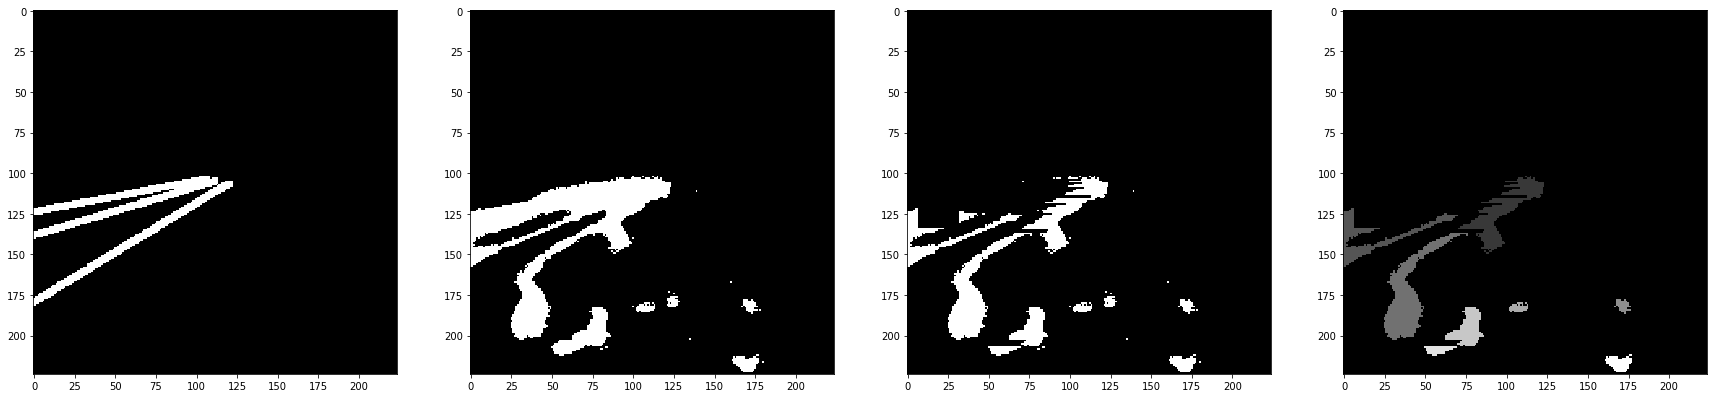

In [120]:
from sklearn.cluster import DBSCAN

def matrix_to_point(matrix):
    points = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if(matrix[x][y] == 1):
                points.append([x, y])
    return np.array(points, dtype=np.uint8)

def get_cluster_points(points, EPS = 1.5, MIN_SAMPLES = 3, minN=20):
    if len(points) == 0: 
        cluster_points = []
    else:
        arpoints = np.array(points, dtype=np.uint8)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        cluster_points = []
        for label in range(-1, max_label+1):
            label_index = np.where(cluster_label == label)
            if(len(label_index[0]) > minN):
                cluster_points.append(arpoints[label_index])
    return np.array(cluster_points)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

# test_index = random.randint(0, len(val_labels))
test_index = 733
test_label = val_labels[test_index,:,:,1]
test_image = val_images[test_index]
test_crf = crf_image(test_image, model, gdims=(3,3), bdims=(7,7), iteras=1)
test_cut = cut_shit(test_crf, 40, frac=0.63)
points_data = matrix_to_point(test_cut)
clusters = get_cluster_points(points_data, EPS = 1.9, MIN_SAMPLES = 3, minN=50)
cluster_img = cluster_to_img(clusters, DATA_SHAPE)
print(test_index, len(clusters))
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_label,cmap='gray')
axs[1].imshow(test_crf,cmap='gray')
axs[2].imshow(test_cut,cmap='gray')
axs[3].imshow(cluster_img,cmap='gray')
plt.show()

# Save json

In [121]:
def cut_cluster_lines(mask_list):
    result = []
    for mask in tqdm(mask_list):
        cut_mask = cut_shit(mask, 30, frac=0.6)
        points_data = matrix_to_point(cut_mask)
        clusters = get_cluster_points(points_data, EPS = 3., MIN_SAMPLES = 3, minN=50)
        result.append(clusters)
    return result

val_clusters = cut_cluster_lines(val_masks)
test_clusters = cut_cluster_lines(test_masks)

100%|██████████| 2034/2034 [13:01<00:00,  2.60it/s]


In [122]:
import datetime
TIMEFORMAT = '%m-%d-%H:%M:%S'
time = datetime.datetime.now().strftime(TIMEFORMAT)
np.save("/home/mc16/result/val_cluster_%s.npy"%time, val_clusters)
time = datetime.datetime.now().strftime(TIMEFORMAT)
np.save("/home/mc16/result/test1_cluster_%s.npy"%time, test_clusters)

In [119]:
import json
def np2json(arlines):
    json_lines = []
    for arline in arlines:
        json_line = []
        for point in arline:
            json_line.append({"x":int(point[1]), "y":int(point[0])})
        json_lines.append(json_line)
    return {"Lanes": json_lines}

def save_jsons(lines_list, list_path, json_path):
    test_md5_paths = open(list_path, 'r').readlines()
    for i, lines in tqdm(enumerate(lines_list)):
        md5 = test_md5_paths[i].split('.')[0]
        lines_json = np2json(lines)
        lines_str = json.dumps(lines_json)
        file = open(json_path + '%s.json'%md5,'w')
        file.write(lines_str)
        file.close()
        
# test_list_path = '/home/mc16/test0_list.txt'
# test_json_path = '/home/mc16/result_json/results/'
# save_jsons(test_lines, test_list_path, test_json_path)

val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_json_path = '/home/mc16/result_json/val_results/'
save_jsons(val_clusters, val_list_path, val_json_path)

2015it [00:06, 300.74it/s]
